In [4]:
from PIL import Image
from pathlib import Path
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import random

In [5]:
INPUT = Path('./car_color_dataset')
TRAIN = INPUT / 'train'
TEST = INPUT / 'public_test'

In [6]:
COLORS=os.listdir(TRAIN)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'car_color_dataset\\train'

In [ ]:
KERNELS=[
    [
        [3, 0, -3],
        [10, 0, -10],
        [3, 0, -3]
    ],
    [
        [3, 10, 3],
        [0, 0, 0],
        [-3, -10, -3]
    ],
    [
        [10, 3, 0],
        [3, 0, -3],
        [0, -3, -10]
    ],
    [
        [0, 3, 10],
        [-3, 0, 3],
        [-10, -3, 0]
    ],
    # [
    #     [1, 1, 1],
    #     [1, -9, 1],
    #     [1, 1, 1]
    # ],
    # [
    #     [1, 1, 1],
    #     [1, 0, 0],
    #     [1, 0, -5]
    # ],
    # [
    #     [1, 1, 1],
    #     [0, 0, 1],
    #     [-5, 0, 1]
    # ],
    # [
    #     [1, 0, -5],
    #     [1, 0, 0],
    #     [1, 1, 1]
    # ]
]

In [ ]:
def conv(img, kernel):
    return cv2.filter2D(np.array(img), -1, kernel)

In [ ]:
def get_bounds(img):
    kerneled_imges = [conv(img, np.array(kernel)) for kernel in KERNELS]
    result = kerneled_imges[0]
    for img_k in kerneled_imges[1:]:
        result += img_k
    result = result // len(KERNELS)
    return Image.fromarray(result)

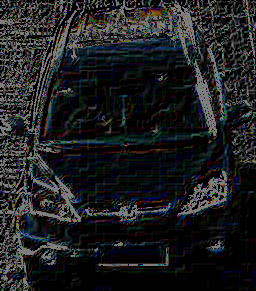

In [ ]:
get_bounds(img)

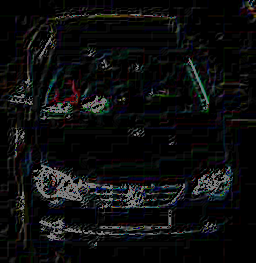

In [ ]:
img2=Image.open(TRAIN / 'Black' / '1005.jpg')
get_bounds(img2)

In [ ]:
def get_all_images(color):
    all = os.listdir(TRAIN / color)
    images = []
    for i in all:
        images.append(Image.open(TRAIN / color / i))
    return images

In [ ]:
def get_test_images():
    all = os.listdir(TEST)
    all = [f'{elem}.jpg' for elem in list(sorted([int(elem[:-4]) for elem in all]))]
    images = []
    for i in all:
        images.append(Image.open(TEST / i))
    return images

In [ ]:
def get_only_not_black(image):
    return (np.sum(image, axis=2) != 0).sum()

def get_all(image):
    return np.size(image) // 3

def get_avg_colors(images, len_searcher=get_only_not_black):
    r,g,b=0,0,0
    for image in images:
        arr = np.array(image)
        r1 = arr[:, :, 0].sum()
        g1 = arr[:, :, 1].sum()
        b1 = arr[:, :, 2].sum()
        l = len_searcher(arr)
        if l == 0:
            l = 1
        r += r1 / l; g += g1 / l; b += b1 / l
    return np.array([r,g,b])/len(images)

def get_std_colors(images, mean, len_searcher=get_only_not_black):
    rgb = np.array([0, 0, 0]).astype(float)
    for image in images:
        arr = np.array(image)
        r1 = arr[:, :, 0].sum()
        g1 = arr[:, :, 1].sum()
        b1 = arr[:, :, 2].sum()
        l = len_searcher(arr)
        if l == 0:
            l = 1
        cur_mean = np.array([r1, g1, b1]).astype(float)
        cur_mean /= l
        rgb += (cur_mean - mean) ** 2
    return np.sqrt(rgb / len(images)) 

In [ ]:
images_black=get_all_images('Black')

In [ ]:
images_orange=get_all_images('Orange')

In [ ]:
get_avg_colors(images_black)

array([42.607012  , 46.87095355, 49.46451892])

In [ ]:
get_avg_colors(images_orange)

array([119.90079065, 100.20975413,  88.24193917])

In [ ]:
def train(data):
    m = {color:get_avg_colors(data[color]) for color in tqdm(data)}
    d = {color:get_std_colors(data[color], m[color]) for color in tqdm(data)}
    mean = np.mean(list(m.values()), axis=0)
    m = {color:m[color] - mean for color in m}
    return {
        'mean': mean,
        'means': m,
        'stds': d
    }

In [ ]:
def plot_trained(d):
    plt.bar(d.keys(),np.array(list(d.values()))[:,0], color='red', alpha=1)
    plt.bar(d.keys(),np.array(list(d.values()))[:,1], color='green', alpha=0.8)
    plt.bar(d.keys(),np.array(list(d.values()))[:,2], color='blue', alpha=0.4)

In [ ]:
images = {key:get_all_images(key) for key in COLORS}
d = train(images)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
d

{'mean': array([91.12362595, 89.73631742, 88.92175551]),
 'means': {'Black': array([-48.42779734, -42.76936607, -39.35548313]),
  'Blue': array([10.63523332, 18.32737786, 30.6542008 ]),
  'Brown': array([22.43668637, 16.94308483,  8.85041667]),
  'Cyan': array([-16.919978  ,   5.37144372,  17.04956066]),
  'Green': array([-0.3233482 , 12.78743341, 10.63422003]),
  'Grey': array([26.44629162, 29.20745079, 29.32536145]),
  'Orange': array([29.29500937, 10.82613844, -0.40243874]),
  'Red': array([-22.82064351, -39.57778564, -37.93358902]),
  'Violet': array([ 9.35685813,  0.09178807, 15.37388681]),
  'White': array([0.10367029, 4.61963924, 4.8683001 ]),
  'Yellow': array([ -9.78198206, -15.82720464, -39.06443564])},
 'stds': {'Black': array([47.25258192, 46.39317963, 46.50693356]),
  'Blue': array([33.02379328, 32.25288921, 32.89876265]),
  'Brown': array([28.77652763, 28.78396727, 31.24134593]),
  'Cyan': array([27.61802926, 25.06878593, 25.14130693]),
  'Green': array([25.8441853 , 27.5

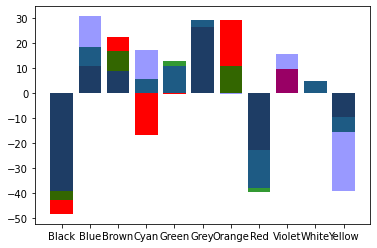

In [ ]:
plot_trained(d['means'])

In [ ]:

def euclid(x, y):
    return np.sum((x - y) ** 2)

def cosine(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    
def make_prediction(image, model, metric=cosine, top=None):
    avg=get_avg_colors([image]) - model['mean']
    keys = list(model['means'].keys())
    dists = [metric(avg / model['stds'][key], model['means'][key] / model['stds'][key]) for key in keys]
    if top is not None:
        return np.array(keys)[np.argsort(dists)[::-1][:top]]
    ind = np.argmax(dists)
    return keys[ind]

def make_predictions(color, model, metric=cosine, top=None):
    images = get_all_images(color)
    predicts = [make_prediction(image, model, metric, top) for image in images]
    return predicts

def make_predictions_for(images, model, metric=cosine, top=None):
    predicts = [make_prediction(image, model, metric, top) for image in images]
    return predicts

def make_predictions_for_each(images_dict, model, metric=cosine, top=None):
    predicts = {key:make_predictions_for(images_dict[key], model, metric, top) for key in images_dict}
    return predicts


In [ ]:
predicts = {key:make_predictions(key, d, metric=cosine) for key in tqdm(COLORS)}

In [ ]:
def calc_acc(color, predicts):
    return (np.array(predicts) == color).mean()

def calc_recall(color, all_predicts, top=False):
    if top:
        return np.array([color in elem for elem in all_predicts[color]]).mean()
    return (np.array(all_predicts[color]) == color).mean()    

def calc_precision(color, all_predicts, top=False):
    
    true_positive = (np.array(all_predicts[color]) == color).sum()
    false_positive = sum([(np.array(all_predicts[key]) == color).sum() for key in all_predicts])
    if (true_positive + false_positive) == 0:
        return 0
    return true_positive / (true_positive + false_positive)

def calc_f1(color, all_predicts):
    rec = calc_recall(color, all_predicts)
    pres = calc_precision(color, all_predicts)
    if rec + pres == 0:
        return 0
    return 2 * rec * pres / (rec + pres)

def calculate_metrics(predicts):
    return {key:[calc_recall(key, predicts), calc_precision(key, predicts), calc_f1(key, predicts), len(predicts[key])] for key in predicts}

def calculate_result_metrics(metrics):
    recall = sum([metrics[key][0] * metrics[key][-1] for key in metrics]) / sum([metrics[key][-1] for key in metrics])
    precision = sum([metrics[key][1] * metrics[key][-1] for key in metrics]) / sum([metrics[key][-1] for key in metrics])
    F1_micro = sum([metrics[key][2] * metrics[key][-1] for key in metrics]) / sum([metrics[key][-1] for key in metrics])
    F1_macro = 2 * recall * precision / (recall + precision)
    return {
        'recall': recall, 
        'precision': precision, 
        'F1_micro': F1_micro, 
        'F1_macro': F1_macro
    }

def make_report(predicts):
    metrics = calculate_metrics(predicts)
    result_metrics = calculate_result_metrics(metrics)
    return metrics, result_metrics

metrics = {key:[calc_recall(key, predicts), calc_precision(key, predicts), calc_f1(key, predicts), len(predicts[key])] for key in predicts}
metrics

{'Black': [0.7761194029850746, 0.24018475750577367, 0.3668430335097002, 402],
 'Blue': [0.2711267605633803, 0.2682926829268293, 0.2697022767075307, 284],
 'Brown': [0.23333333333333334, 0.09186351706036745, 0.13182674199623354, 150],
 'Cyan': [0.37453183520599254, 0.3246753246753247, 0.34782608695652173, 267],
 'Green': [0.05947955390334572, 0.3333333333333333, 0.10094637223974762, 269],
 'Grey': [0.5795795795795796, 0.19653767820773932, 0.2935361216730038, 333],
 'Orange': [0.2764811490125673, 0.3228511530398323, 0.29787234042553196, 557],
 'Red': [0.38593155893536124, 0.334983498349835, 0.3586572438162544, 526],
 'Violet': [0.147239263803681, 0.43636363636363634, 0.22018348623853215, 163],
 'White': [0.0267639902676399, 0.10784313725490197, 0.042884990253411304, 411],
 'Yellow': [0.4727272727272727, 0.3525423728813559, 0.4038834951456311, 440]}

In [ ]:
calculate_result_metrics(metrics)

{'recall': 0.3506049447659127,
 'precision': 0.2774670714907378,
 'F1_micro': 0.27548790273586227,
 'F1_macro': 0.3097776202613599}

In [ ]:
predicts_eu = make_predictions_for_each(images, d, euclid)
metrics_eu = calculate_metrics(predicts_eu)
metrics_eu

{'Black': [0.2064676616915423, 0.0367094206103494, 0.062335711603454746, 402],
 'Blue': [0.0, 0.0, 0, 284],
 'Brown': [0.0, 0, 0, 150],
 'Cyan': [0.0, 0, 0, 267],
 'Green': [0.0, 0, 0, 269],
 'Grey': [0.0990990990990991, 0.019987886129618413, 0.03326612903225807, 333],
 'Orange': [0.0, 0, 0, 557],
 'Red': [0.0, 0.0, 0, 526],
 'Violet': [0.0, 0, 0, 163],
 'White': [0.0, 0, 0, 411],
 'Yellow': [0.0, 0, 0, 440]}

In [ ]:
calculate_result_metrics(metrics_eu)

{'recall': 0.03051025775907417,
 'precision': 0.005632076056423828,
 'F1_micro': 0.009504623101612507,
 'F1_macro': 0.009508854247066737}

In [ ]:
test_pred = make_predictions_for(get_test_images(), d, metric=cosine)
pd.Series(test_pred)

0        Cyan
1       White
2         Red
3       White
4        Cyan
        ...  
1431      Red
1432    Green
1433    Brown
1434     Blue
1435     Grey
Length: 1436, dtype: object

In [ ]:
pd.Series(test_pred).to_csv('test_pred.csv', index=False, header=False)

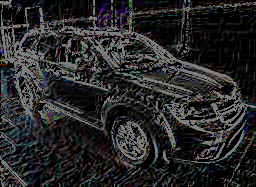

In [ ]:
step1 = get_bounds(images_black[1])
step1

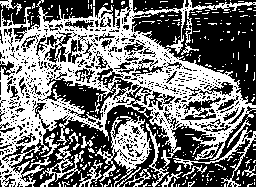

In [ ]:
arr = np.array(step1).tolist()
for i in range(len(arr)):
    for j in range(len(arr[0])):
        arr[i][j] = [255] * 3 if sum(arr[i][j]) > 80 else [0] * 3

step10 = Image.fromarray(np.array(arr).astype('uint8'))
step10

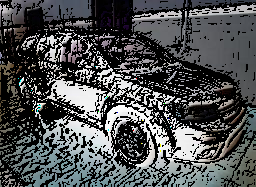

In [ ]:
Image.fromarray(np.array(images_black[1]) * (255 - np.array(step10)))

In [ ]:
def process_image(image):
    img = np.array(image)
    step1 = get_bounds(image)

    step10 = np.array(step1)
    step10[np.sum(step10, axis=2) > 80] = 1
    step10[step10 != 1] = 0

    step20 = img * step10

    # step30 = cv2.fastNlMeansDenoisingColored(step20, None, 10, 10, 7, 25)
    step30 = conv(step20, np.array([1 * 3] * 3) / 9)
    # step30 = step20
    mask1 = np.sum(step30, axis=2) < 100
    mask2 = np.sum(step30, axis=2) > 700
    mask3 = np.std(step30, axis=2) < 40
    step30[mask1] = 0
    step30[mask2] = 0
    step30[mask3] = 0
    step30[~(mask1 | mask2 | mask3)] = 1

    step40 = img * step30
    return Image.fromarray(step40)

def process_images(images):
    return [process_image(image) for image in images]

In [ ]:
processed = {key:process_images(get_all_images(key)) for key in tqdm(COLORS)}

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 0/440 [00:00<?, ?it/s]

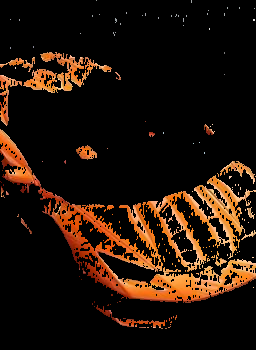

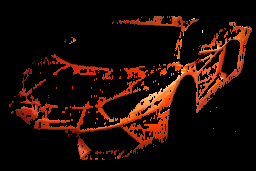

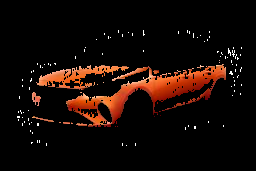

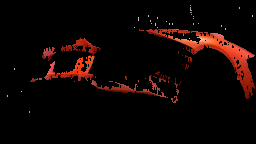

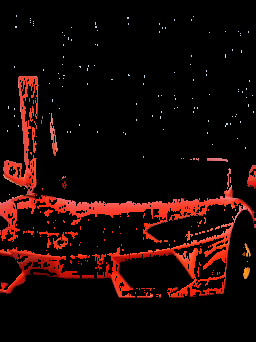

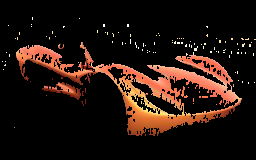

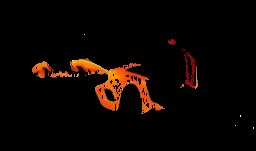

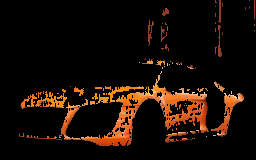

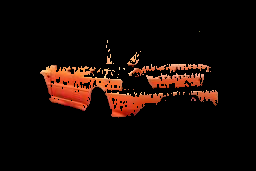

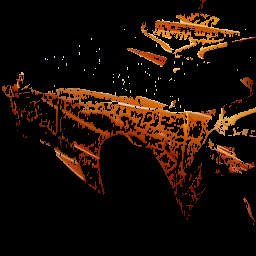

In [ ]:
display(*processed['Orange'][:10])

In [ ]:
PROCESSED = INPUT / 'processed_train5'
os.makedirs(PROCESSED, exist_ok=True)

for key in tqdm(processed):
    os.makedirs(PROCESSED / key)
    names = os.listdir(TRAIN / key)
    for image, name in zip(processed[key], names):
        image.save(PROCESSED / key / name)

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
model = train(processed)
model

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'mean': array([150.84791226, 134.79933379, 133.36562217]),
 'means': {'Black': array([-33.91463629, -13.47192282, -12.34314936]),
  'Blue': array([-80.17537453, -33.55107049,  38.16930244]),
  'Brown': array([32.96656722, 21.76113138, -0.7450686 ]),
  'Cyan': array([-73.16089332,  31.32831939,  69.15720886]),
  'Green': array([-4.62304812, 35.74531239, 23.03154507]),
  'Grey': array([36.11277042, 45.6356087 , 40.20873309]),
  'Orange': array([ 52.83210693, -33.46886549, -87.82691439]),
  'Red': array([ -8.52890062, -86.53440604, -85.79833141]),
  'Violet': array([ -8.72325467, -49.66683099,  31.7138258 ]),
  'White': array([41.04739821, 60.32158447, 59.95544149]),
  'Yellow': array([ 46.16726475,  21.9011395 , -75.52259298])},
 'stds': {'Black': array([88.77089103, 86.34802038, 91.80884627]),
  'Blue': array([47.76837035, 34.95130006, 28.03740372]),
  'Brown': array([39.13946645, 52.86732011, 66.17568885]),
  'Cyan': array([37.0024559 , 27.41078148, 20.60795942]),
  'Green': array([59

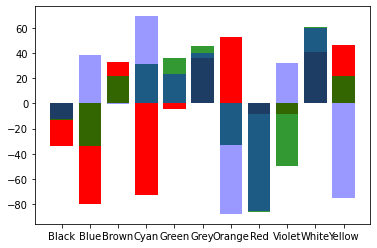

In [ ]:
plot_trained(model['means'])

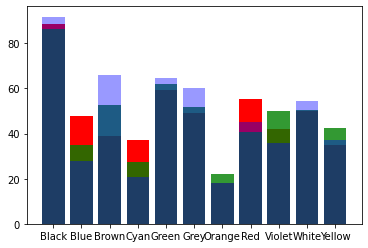

In [ ]:
plot_trained(model['stds'])

In [ ]:
ppredictios = make_predictions_for_each(processed, model, cosine)

In [ ]:
metrics, result_metrics = make_report(ppredictios)
metrics

{'Black': [0.31343283582089554, 0.2978723404255319, 0.3054545454545455, 402],
 'Blue': [0.7359154929577465, 0.4003831417624521, 0.5186104218362283, 284],
 'Brown': [0.13333333333333333, 0.09216589861751152, 0.108991825613079, 150],
 'Cyan': [0.7752808988764045, 0.3657243816254417, 0.4969987995198079, 267],
 'Green': [0.20817843866171004, 0.29015544041450775, 0.2424242424242424, 269],
 'Grey': [0.2732732732732733, 0.1961206896551724, 0.22835633626097865, 333],
 'Orange': [0.8384201077199281, 0.40857392825896766, 0.5494117647058824, 557],
 'Red': [0.7167300380228137, 0.40712742980561556, 0.5192837465564738, 526],
 'Violet': [0.5460122699386503, 0.49171270718232046, 0.5174418604651163, 163],
 'White': [0.30170316301703165, 0.22423146473779385, 0.2572614107883817, 411],
 'Yellow': [0.5818181818181818, 0.4025157232704403, 0.4758364312267658, 440]}

In [ ]:
result_metrics

{'recall': 0.5318253550762756,
 'precision': 0.3365141290267856,
 'F1_micro': 0.40478469701065,
 'F1_macro': 0.41220455693711777}

In [ ]:
test = get_test_images()

In [ ]:
test_processed = process_images(test)

  0%|          | 0/1436 [00:00<?, ?it/s]

In [ ]:
os.makedirs(INPUT / 'test_processed')
names = os.listdir(TEST)
for image, name in zip(test_processed, names):
    image.save(INPUT / 'test_processed' / name)

In [ ]:
test_preds = make_predictions_for(test_processed, model, cosine)

In [ ]:
names = os.listdir(TEST)
a = pd.DataFrame({
    'path': names,
    'color': test_preds,
})

In [ ]:
a.path = a.path.apply(lambda elem: int(elem[:-4]))
a = a.sort_values(by='path').reset_index(drop=True)
a.path = a.path.apply(lambda elem: f'{elem}.jpg')
a

,path,color
0,0.jpg,Violet
1,1.jpg,Grey
2,2.jpg,Orange
3,3.jpg,Grey
4,4.jpg,Black
...,...,...
1431,1431.jpg,Orange
1432,1432.jpg,Black
1433,1433.jpg,Blue
1434,1434.jpg,Black


In [ ]:
a.to_excel('to_val.xlsx', index=False)

In [ ]:
a = pd.read_excel('to_val.xlsx')

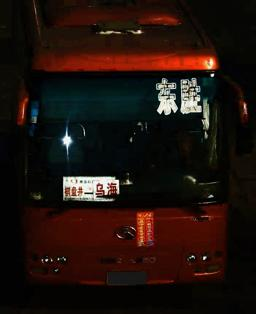

12.jpg


12


In [ ]:
from IPython.display import clear_output

for row in a.iloc:
    clear_output()
    display(Image.open(TEST / row.path))
    print(row.path)
    inp = input(row.color)
    if inp == '-1':
        print(row.name)
        break
    if inp == '':
        continue
    if inp != row.color:
        a.loc[row.name, 'color'] = inp

In [ ]:
a.iloc[0].name

0

In [ ]:
a

,path,color,color_true
0,0.jpg,Violet,Violet
1,1.jpg,Grey,White
2,2.jpg,Orange,Orange
3,3.jpg,Grey,Grey
4,4.jpg,Black,Green
...,...,...,...
1431,1431.jpg,Orange,Yellow
1432,1432.jpg,Black,Black
1433,1433.jpg,Blue,Cyan
1434,1434.jpg,Black,Yellow


In [ ]:
a.color.to_csv('output2.csv', index=False, header=False)

In [ ]:
validated = pd.read_excel('validated.xlsx')

In [ ]:
validated.color.to_csv('validated.csv', index=False, header=False)

In [ ]:
a['color_true'] = validated['color']

In [ ]:
a['color'].value_counts()

White     270
Orange    270
Red       204
Black     166
Cyan      117
Blue      105
Yellow    102
Grey       61
Violet     54
Brown      53
Green      34
Name: color, dtype: int64

In [ ]:
pd.Series(np.array(test_preds)).value_counts()

White     270
Orange    270
Red       204
Black     166
Cyan      117
Blue      105
Yellow    102
Grey       61
Violet     54
Brown      53
Green      34
dtype: int64

In [ ]:
new3 = make_predictions_for_each(processed, model, cosine, 3)
new1 = make_predictions_for_each(processed, model, cosine, None)
new2 = make_predictions_for_each(processed, model, cosine, 2)

In [ ]:
new5 = make_predictions_for_each(processed, model, cosine, 5)

In [ ]:
pd.DataFrame({
    # 'top5': {key:calc_recall(key, new5, top=True) for key in COLORS},
    'top3': {key:calc_recall(key, new3, top=True) for key in COLORS},
    'top2': {key:calc_recall(key, new2, top=True) for key in COLORS},
    'top1': {key:calc_recall(key, new1, top=False) for key in COLORS}
})

,top3,top2,top1
Black,0.445274,0.340796,0.268657
Blue,0.873239,0.869718,0.795775
Brown,0.346667,0.193333,0.113333
Cyan,0.898876,0.887640,0.749064
Green,0.650558,0.360595,0.230483
Grey,0.738739,0.681682,0.168168
Orange,0.998205,0.991023,0.845601
Red,0.931559,0.908745,0.688213
Violet,0.785276,0.699387,0.558282
White,0.815085,0.727494,0.518248


In [ ]:
class Evaluater:
    def __init__(self, class_predictions):
        self.preds = class_predictions
        self.lengths = {key:len(self.preds[key]) for key in self.preds}
        self.sum_length = np.sum([self.lengths[key] for key in self.preds])

    def recallOneClass(self, class_name):
        real = self.preds[class_name]
        tp = [(1 if class_name in elem else 0) for elem in real]
        return np.sum(tp) / len(tp)

    def precisionOneClass(self, class_name):
        positives = np.sum([np.sum([elem[0] == class_name for elem in self.preds[key]]) for key in self.preds])
        tp = [(1 if elem[0] == class_name else 0) for elem in self.preds[class_name]]
        return np.sum(tp) / positives

    def f1ScoreOneClass(self, class_name):
        recall = self.recallOneClass(class_name)
        precision = self.precisionOneClass(class_name)
        return 2 * recall * precision / (recall + precision)

    def metrics(self, metric_function):
        return {key:metric_function(key) for key in self.preds}

    def recalls(self):
        return self.metrics(self.recallOneClass)

    def precisions(self):
        return self.metrics(self.precisionOneClass)

    def f1Scores(self):
        return self.metrics(self.f1ScoreOneClass)

    def metric(self, metrics_function):
        metrics = metrics_function()
        sum = np.sum([metrics[key] * self.lengths[key] for key in metrics])
        return sum / self.sum_length

    def recall(self):
        return self.metric(self.recalls)

    def precision(self):
        return self.metric(self.precisions)

    def f1ScoreMicro(self):
        return self.metric(self.f1Scores)

    def f1ScoreMacro(self):
        recall = self.recall()
        precision = self.precision()
        return 2 * recall * precision / (recall + precision)

    def reportClasses(self):
        return pd.DataFrame({
            'recall': self.recalls(),
            'precision': self.precisions(),
            'f1Score': self.f1Scores(),
            'count': self.lengths
        })

    def reportCommon(self):
        return pd.DataFrame({
            'recall': [self.recall()],
            'precision': [self.precision()],
            'f1ScoreMicro': [self.f1ScoreMicro()],
            'f1ScoreMacro': [self.f1ScoreMacro()]
        }, index=['all_classes'])

In [ ]:
class Model:
    def __init__(self, classes):
        self.classes = np.array(classes)
    
    def fit(self, data):
        pass

    def predictOne(self, image, top):
        return {random.choice(self.classes):1.0 for _ in range(top)}

    def predict(self, images, top=1):
        return [list(self.predictOne(image, top).keys()) for image in images]

    def predict_for_dict(self, dictio, top=1):
        return {key:self.predict(dictio[key], top) for key in tqdm(dictio)}

    def __call__(self, image, top):
        return self.predict(image, top)

In [ ]:
class OnlyByMedians(Model):
    def __init__(self, classes):
        super().__init__(classes)
        self.means = {key:np.random.rand(3) for key in classes}
        self.mean = np.array(list(self.means.values())).mean(axis=0)
        for key in self.means:
            self.means[key] -= self.mean
        
    def fit(self, data):
        data = {key:process_images(data[key]) for key in data}
        m = {color:get_avg_colors(data[color]) for color in tqdm(data)}
        mean = np.mean(list(m.values()), axis=0)
        m = {color:m[color] - mean for color in m}
        self.means = m
        self.mean = mean

    def predictOne(self, image, top=1, metric=cosine):
        processed = process_image(image)
        rgb = get_avg_colors([processed])
        rgb -= self.mean
        dists = [metric(rgb, self.means[key]) for key in self.classes]
        inds = np.argsort(dists)[::-1][:top]
        return {self.classes[ind]:dists[ind] for ind in inds}

In [ ]:
class ByMediansAndStd(Model):
    def __init__(self, classes):
        super().__init__(classes)
        self.means = {key:np.random.rand(3) for key in classes}
        self.stds = {key:np.random.rand(3) for key in classes}
        self.mean = np.array(list(self.means.values())).mean(axis=0)
        for key in self.means:
            self.means[key] -= self.mean
        
    def fit(self, data):
        data = {key:process_images(data[key]) for key in data}
        m = {color:get_avg_colors(data[color]) for color in tqdm(data)}
        d = {color:get_std_colors(data[color], m[color]) for color in tqdm(data)}
        mean = np.mean(list(m.values()), axis=0)
        m = {color:(m[color] - mean) / d[color] for color in m}
        self.means = m
        self.mean = mean
        self.stds = d

    def predictOne(self, image, top=1, metric=cosine):
        processed = process_image(image)
        display(processed)
        rgb = get_avg_colors([processed])
        rgb -= self.mean
        dists = [metric(rgb / self.stds[key], self.means[key]) for key in self.classes]
        inds = np.argsort(dists)[::-1][:top]
        return {self.classes[ind]:dists[ind] for ind in inds}

In [ ]:
model1 = OnlyByMedians(COLORS)
model2 = ByMediansAndStd(COLORS)

In [ ]:
model1.fit(images)
model2.fit(images)

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 0/440 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 0/440 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
model1.predictOne(images['Orange'][1], 3)

{'Orange': 0.9827649643128812,
 'Red': 0.8555060457910876,
 'Yellow': 0.7395490781799818}

In [ ]:
model2.predictOne(images['Orange'][1], 3)

{'Orange': 0.986646661890386,
 'Red': 0.8943077861263713,
 'Yellow': 0.80011554625111}

In [ ]:
predicts_new1 = model1.predict_for_dict(images, 1)
predicts_new2 = model2.predict_for_dict(images, 1)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
evaluater1 = Evaluater(predicts_new1)
evaluater2 = Evaluater(predicts_new2)

In [ ]:
evaluater1.reportClasses()

,recall,precision,f1Score,count
Black,0.296020,0.449057,0.356822,402
Blue,0.792254,0.639205,0.707547,284
Brown,0.066667,0.068493,0.067568,150
Cyan,0.745318,0.614198,0.673435,267
Green,0.223048,0.368098,0.277778,269
Grey,0.276276,0.245333,0.259887,333
Orange,0.850987,0.675214,0.752979,557
Red,0.695817,0.701149,0.698473,526
Violet,0.564417,0.958333,0.710425,163
White,0.311436,0.291572,0.301176,411


In [ ]:
evaluater2.reportClasses()

,recall,precision,f1Score,count
Black,0.313433,0.424242,0.360515,402
Blue,0.735915,0.667732,0.700168,284
Brown,0.133333,0.101523,0.115274,150
Cyan,0.775281,0.576602,0.661342,267
Green,0.208178,0.408759,0.275862,269
Grey,0.273273,0.243968,0.257790,333
Orange,0.838420,0.690828,0.757502,557
Red,0.716730,0.686703,0.701395,526
Violet,0.546012,0.967391,0.698039,163
White,0.301703,0.289044,0.295238,411


In [ ]:
print(evaluater1.reportCommon())
print(evaluater2.reportCommon())

               recall  precision  f1ScoreMicro  f1ScoreMacro
all_classes  0.537612   0.534366      0.528179      0.535984
               recall  precision  f1ScoreMicro  f1ScoreMacro
all_classes  0.531825   0.536418      0.525621      0.534112


In [ ]:
test_images = get_test_images()

In [ ]:
predicts1 = model1.predict(test_images, 3)
predicts2 = model2.predict(test_images, 3)

In [ ]:
a = pd.read_excel('validated.xlsx')

In [ ]:
a['pred1'] = predicts1
a['pred2'] = predicts2

In [ ]:
a[a.pred1 != a.pred2]

,path,color,pred1,pred2
1,1.jpg,White,"[Grey, White, Green]","[Grey, White, Brown]"
3,3.jpg,Grey,"[White, Grey, Green]","[Grey, White, Brown]"
4,4.jpg,Green,"[Black, Red, Blue]","[Black, Red, Orange]"
7,7.jpg,Cyan,"[Cyan, Blue, Green]","[Cyan, Green, Blue]"
8,8.jpg,Blue,"[Black, Blue, Violet]","[Black, Blue, Red]"
...,...,...,...,...
1420,1420.jpg,Grey,"[Grey, White, Green]","[Grey, White, Brown]"
1423,1423.jpg,Yellow,"[Yellow, Brown, Orange]","[Brown, Yellow, Orange]"
1426,1426.jpg,Grey,"[Cyan, Blue, Green]","[Cyan, Green, Blue]"
1432,1432.jpg,Black,"[Black, Red, Blue]","[Black, Red, Orange]"


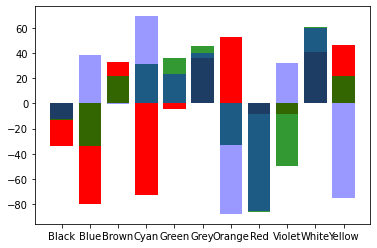

In [ ]:
plot_trained(model1.means)

In [ ]:
model1.predictOne(test_images[2], 3)

{'Black': 0.9189732117088567,
 'Red': 0.8241354097626242,
 'Blue': 0.5011336543827538}

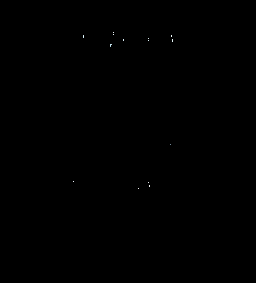

In [ ]:
process_image(test_images[])

In [ ]:
import numpy as np
from PIL import Image
np.array(Image.open('data/train/Black/1000.jpg'))

array([[[ 80,  90,  92],
        [ 71,  81,  83],
        [ 74,  84,  86],
        ...,
        [ 19,  44,  51],
        [ 16,  43,  50],
        [ 30,  57,  64]],

       [[ 68,  76,  79],
        [ 71,  81,  82],
        [ 63,  71,  74],
        ...,
        [ 18,  43,  50],
        [ 15,  42,  49],
        [ 30,  57,  64]],

       [[ 58,  63,  66],
        [ 68,  77,  76],
        [ 55,  60,  63],
        ...,
        [ 10,  35,  42],
        [ 10,  35,  42],
        [ 25,  50,  57]],

       ...,

       [[109, 111, 108],
        [129, 131, 126],
        [118, 118, 116],
        ...,
        [  3,  12,  19],
        [  3,  12,  19],
        [  2,  11,  18]],

       [[120, 122, 117],
        [130, 132, 127],
        [117, 118, 113],
        ...,
        [  3,  12,  21],
        [  3,  12,  21],
        [  2,  11,  20]],

       [[134, 136, 131],
        [131, 133, 128],
        [115, 116, 111],
        ...,
        [  3,  12,  21],
        [  3,  12,  21],
        [  2,  11,  20]]

In [ ]:
np.array(Image.open('data/train/Black/1000.jpg')).transpose(2, 0, 1).reshape(3, -1).sum(axis=1)

array([2465612, 3397674, 4098450], dtype=uint32)

In [ ]:
from processor import Processor
from dataLoader import load_test, load_train

a, b = load_train()
p = Processor()
{key: p.process_images(a[key]) for key in a}

100%|██████████| 11/11 [00:01<00:00,  7.24it/s]


{'Black': [<PIL.Image.Image image mode=RGB size=256x291 at 0x1F14A44FF70>,
  <PIL.Image.Image image mode=RGB size=256x187 at 0x1F14873B6A0>,
  <PIL.Image.Image image mode=RGB size=256x276 at 0x1F14873B8B0>,
  <PIL.Image.Image image mode=RGB size=256x244 at 0x1F14873AB30>,
  <PIL.Image.Image image mode=RGB size=256x255 at 0x1F14873B1C0>,
  <PIL.Image.Image image mode=RGB size=256x263 at 0x1F14873ADD0>,
  <PIL.Image.Image image mode=RGB size=256x244 at 0x1F14873B520>,
  <PIL.Image.Image image mode=RGB size=256x217 at 0x1F14873B190>,
  <PIL.Image.Image image mode=RGB size=256x256 at 0x1F14873BA00>,
  <PIL.Image.Image image mode=RGB size=256x246 at 0x1F14873BD60>,
  <PIL.Image.Image image mode=RGB size=256x263 at 0x1F14873B850>,
  <PIL.Image.Image image mode=RGB size=256x256 at 0x1F14873B4C0>,
  <PIL.Image.Image image mode=RGB size=256x264 at 0x1F14A747F70>,
  <PIL.Image.Image image mode=RGB size=256x192 at 0x1F135A32C50>,
  <PIL.Image.Image image mode=RGB size=256x195 at 0x1F135A32CE0>,
 

In [ ]:
from processor import Processor
from useDecisionTree import UseDecisionTree
from dataLoader import load_train, load_test
from constants import COLORS

p = Processor()
train_d, _ = load_train()
test_d, _ = load_test()

100%|██████████| 11/11 [00:30<00:00,  2.79s/it]


In [ ]:
model = UseDecisionTree(COLORS, p, 8)
model.fit(train_d)

100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


In [ ]:
model.predictOne(test_d[3], 3)

{'Grey': 0.3565217391304348,
 'White': 0.34782608695652173,
 'Black': 0.1565217391304348}

In [ ]:
from evaluater import Evaluater

In [ ]:
from tqdm import tqdm
train_predicts = {key:model.predict(train_d[key]) for key in tqdm(train_d)}

100%|██████████| 11/11 [00:49<00:00,  4.49s/it]


In [ ]:
ev = Evaluater(train_predicts)

In [ ]:
ev.reportClasses()

,recall,precision,f1Score,count
Black,0.654229,0.840256,0.735664,402
Blue,0.830986,0.893939,0.861314,284
Brown,0.186667,0.405797,0.255708,150
Cyan,0.853933,0.919355,0.885437,267
Green,0.613383,0.550000,0.579965,269
Grey,0.624625,0.416834,0.500000,333
Orange,0.917415,0.888696,0.902827,557
Red,0.899240,0.861566,0.880000,526
Violet,0.754601,0.831081,0.790997,163
White,0.545012,0.554455,0.549693,411


In [ ]:
ev.reportCommon()

,recall,precision,f1ScoreMicro,f1ScoreMacro
all_classes,0.747764,0.759205,0.748374,0.753441


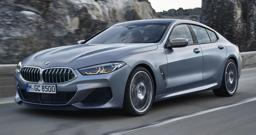

In [ ]:
test_d[3]

In [ ]:
from sklearn import tree
import pickle

s = pickle.dumps(model.clf)
pickle.loads(s)

DecisionTreeClassifier(max_depth=8)

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(model.clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
from processor import Processor
from PIL import Image
import numpy as np

In [ ]:
p = Processor()

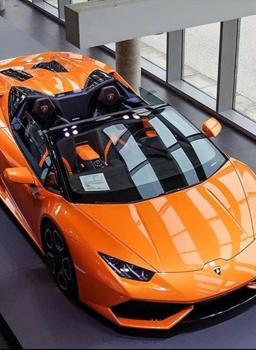

In [ ]:
img = Image.open('../data/train/Orange/1832.jpg')
img

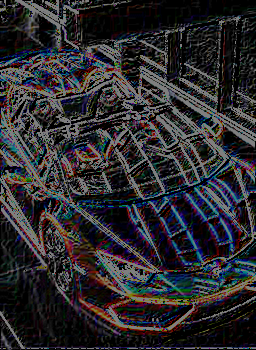

In [ ]:
step1 = p.get_bounds(img)
step1

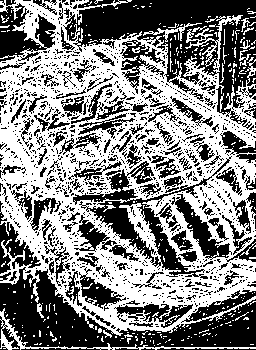

In [ ]:
step10 = np.array(step1)
step10[np.sum(step10, axis=2) > 80] = 255
step10[step10 != 255] = 0
Image.fromarray(step10)

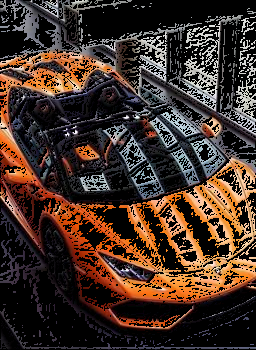

In [ ]:
step20 = np.array(img) * (step10 // 255)
Image.fromarray(step20)

In [ ]:
mask1 = np.sum(step20, axis=2) < 300
mask2 = np.sum(step20, axis=2) > 500
mask3 = np.std(step20, axis=2) < 50

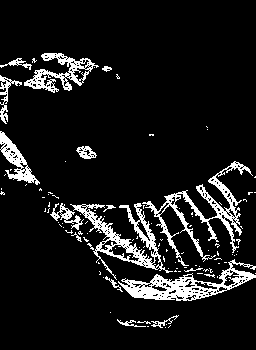

In [ ]:
step30 = step20.copy()
step30[mask1] = 0
step30[mask2] = 0
step30[mask3] = 0
step30[~(mask1 | mask2 | mask3)] = 255
Image.fromarray(step30)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
import pandas as pd
pd.DataFrame({
    'алё': [1, 2, 3],
    'пикча': [img, img, img]
})

,алё,пикча
0,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,3,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [ ]:
model = UseDecisionTree(COLORS, p)

In [ ]:
model.save()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [ ]:
import pickle

pickle.dumps(model.clf)

b'\x80\x04\x95Q\x01\x00\x00\x00\x00\x00\x00\x8c\x15sklearn.tree._classes\x94\x8c\x16DecisionTreeClassifier\x94\x93\x94)\x81\x94}\x94(\x8c\tcriterion\x94\x8c\x04gini\x94\x8c\x08splitter\x94\x8c\x04best\x94\x8c\tmax_depth\x94K\x05\x8c\x11min_samples_split\x94K\x02\x8c\x10min_samples_leaf\x94K\x01\x8c\x18min_weight_fraction_leaf\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x0cmax_features\x94N\x8c\x0emax_leaf_nodes\x94N\x8c\x0crandom_state\x94N\x8c\x15min_impurity_decrease\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x0cclass_weight\x94N\x8c\tccp_alpha\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x10_sklearn_version\x94\x8c\x051.0.2\x94ub.'

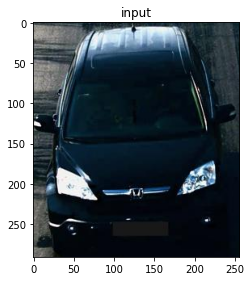

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('../data/train/Black/1000.jpg')
fig = plt.figure(figsize=(125, 25))
ax = fig.add_subplot(5, 1, 1)
image = plt.imshow(img)
ax.set_title('input')
plt.show()

In [ ]:
from processor import Processor

p = Processor()

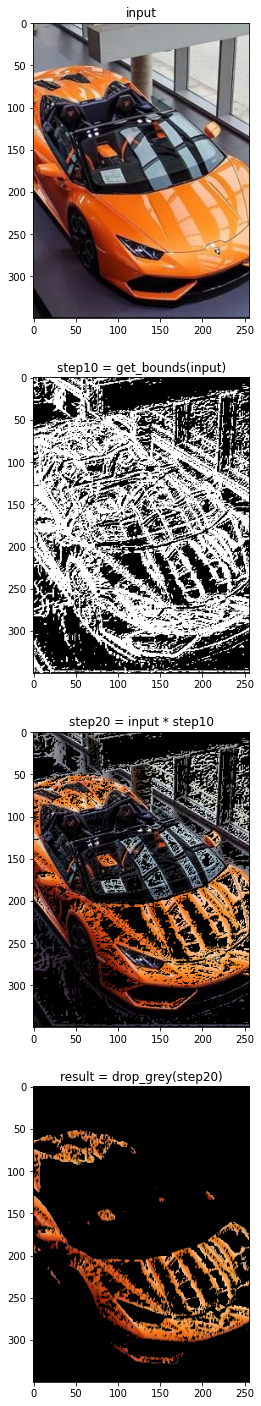

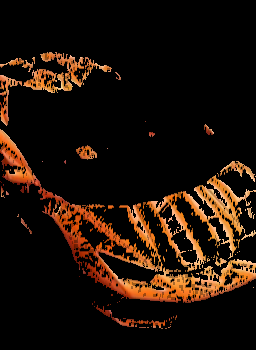

In [ ]:
img = Image.open('../data/train/Orange/1832.jpg')
p.process_image(img)

In [ ]:
from useDecisionTree import UseDecisionTree
from processor import Processor
from dataLoader import load_train
from constants import COLORS

In [ ]:
model = UseDecisionTree(COLORS, None, 5)

In [ ]:
model.fit(load_train()[0])

100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


In [ ]:
model.predictOne(load_train()[0]['Orange'][1], 3)

100%|██████████| 11/11 [00:01<00:00, 10.32it/s]


{'Orange': 0.7317073170731707,
 'Red': 0.24390243902439024,
 'Yellow': 0.024390243902439025}

In [ ]:
model.save()

In [ ]:
model.load_weights('../models\_2022_11_13 04-16-16.json')

In [ ]:
def get_all_variants(n, max_k):
    if n == 0:
        return [[]]
    if n == 1:
        return [[1]]
    results = []
    for i in range(1, min(max_k, n) + 1):
        result = get_all_variants(n - i, i)
        for j in result:
            results.append([i] + j)
    return results

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 1, 1, 1, 1],
 [2, 2, 2, 2, 1, 1],
 [2, 2, 2, 2, 2],
 [3, 1, 1, 1, 1, 1, 1, 1],
 [3, 2, 1, 1, 1, 1, 1],
 [3, 2, 2, 1, 1, 1],
 [3, 2, 2, 2, 1],
 [3, 3, 1, 1, 1, 1],
 [3, 3, 2, 1, 1],
 [3, 3, 2, 2],
 [3, 3, 3, 1],
 [4, 1, 1, 1, 1, 1, 1],
 [4, 2, 1, 1, 1, 1],
 [4, 2, 2, 1, 1],
 [4, 2, 2, 2],
 [4, 3, 1, 1, 1],
 [4, 3, 2, 1],
 [4, 3, 3],
 [4, 4, 1, 1],
 [4, 4, 2],
 [5, 1, 1, 1, 1, 1],
 [5, 2, 1, 1, 1],
 [5, 2, 2, 1],
 [5, 3, 1, 1],
 [5, 3, 2],
 [5, 4, 1],
 [5, 5],
 [6, 1, 1, 1, 1],
 [6, 2, 1, 1],
 [6, 2, 2],
 [6, 3, 1],
 [6, 4],
 [7, 1, 1, 1],
 [7, 2, 1],
 [7, 3],
 [8, 1, 1],
 [8, 2],
 [9, 1],
 [10]]

In [ ]:
import pandas as pd
import os

validated = pd.read_excel('validated_test.xlsx')


In [1]:
from multiModel import MultiModel
from dataLoader import load_test_as_dict, load_train
from processor import Processor
from constants import COLORS

p = Processor()
model = MultiModel(COLORS)
train = load_train()[0]
test = load_test_as_dict()

100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


In [2]:
model.fit(train)

100%|██████████| 3/3 [00:09<00:00,  3.20s/it]


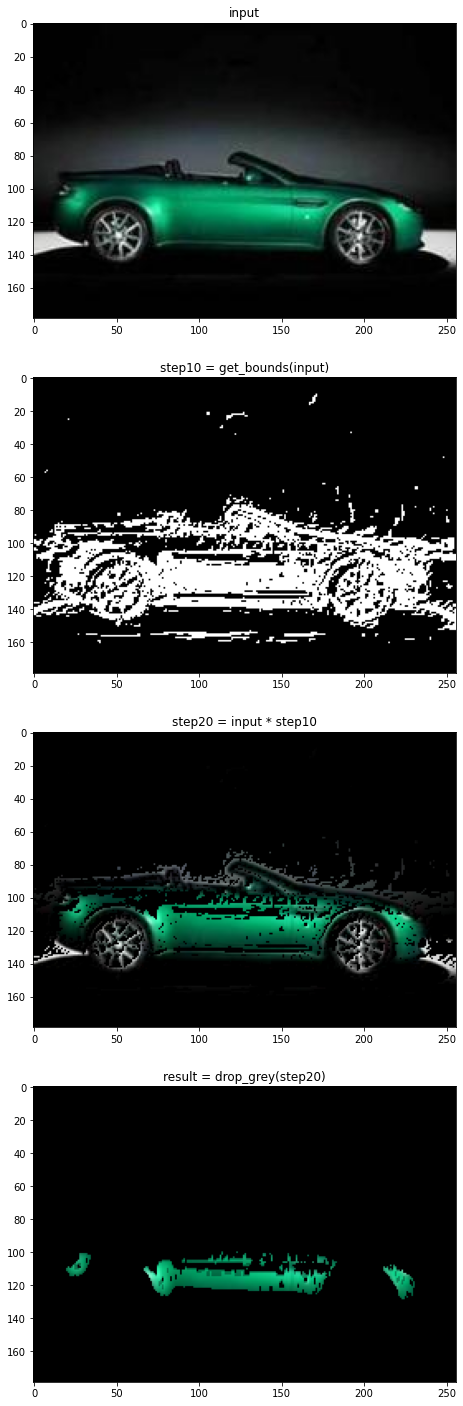

{'Orange': 1.0}

In [8]:
model.predictOne(train['Green'][0], top=1, logging=True)

In [4]:
test_preds = model.predictForDict(test)

100%|██████████| 11/11 [00:49<00:00,  4.48s/it]


In [5]:
from evaluater import Evaluater

ev = Evaluater(test_preds)
ev.reportClasses()

,recall,precision,f1Score,count
Black,0.079602,0.426667,0.134172,402
Blue,0.728873,0.802326,0.763838,284
Brown,0.000000,0.000000,0.000000,150
Cyan,0.850187,0.646724,0.734628,267
Green,0.144981,0.735849,0.242236,269
Grey,0.030030,0.080645,0.043764,333
Orange,0.066427,0.026335,0.037717,557
Red,0.020913,0.019332,0.020091,526
Violet,0.000000,0.000000,0.000000,163
White,0.021898,0.029605,0.025175,411


In [6]:
ev.reportCommon()

,recall,precision,f1ScoreMicro,f1ScoreMacro
all_classes,0.150447,0.219321,0.154832,0.17847


In [8]:
from dataLoader import load_test
predicts = model(load_test()[0], 1)

In [13]:
import pandas as pd
pd.Series([pr[0] for pr in predicts]).to_csv('DecisionTree.csv', index=False, header=False)